<a href="https://colab.research.google.com/github/rahiakela/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/blob/10-introduction-to-artificial-neural-networks-with-keras/saving_and_restoring_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Saving and Restoring a Model

## Setup

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

TensorFlow 2.x selected.
2.0.0


## Load database

Let’s switch to the California housing problem and tackle it using a regression neural network. For simplicity, we will use Scikit-Learn’s fetch_california_housing() function to load the data.

After loading the data, we split it into a training set, a validation set, and a test set, and we scale all the features:

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# load dataset
housing = fetch_california_housing()

# split dataset into traing and test set 
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)

# prepare validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

# scale all the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

In [0]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

In [28]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test, verbose=0)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 95us/sample - loss: 0.3222 - val_loss: 0.3255
Epoch 2/10
11610/11610 [==============================] - 1s 68us/sample - loss: 0.3223 - val_loss: 0.3073
Epoch 3/10
11610/11610 [==============================] - 1s 65us/sample - loss: 0.3218 - val_loss: 0.3158
Epoch 4/10
11610/11610 [==============================] - 1s 65us/sample - loss: 0.3215 - val_loss: 0.3076
Epoch 5/10
11610/11610 [==============================] - 1s 64us/sample - loss: 0.3212 - val_loss: 0.3088
Epoch 6/10
11610/11610 [==============================] - 1s 67us/sample - loss: 0.3210 - val_loss: 0.3380
Epoch 7/10
11610/11610 [==============================] - 1s 65us/sample - loss: 0.3206 - val_loss: 0.3251
Epoch 8/10
11610/11610 [==============================] - 1s 63us/sample - loss: 0.3207 - val_loss: 0.4134
Epoch 9/10
11610/11610 [==============================] - 1s 66us/sample - loss: 0.3206 - val_l

## Saving and Restoring a Model

When using the Sequential API or the Functional API, saving a trained Keras model is as simple as it gets.

Keras will use the HDF5 format to save both the model’s architecture (including every layer’s hyperparameters) and the values of all the model parameters for every layer(connection weights and biases). It also saves the optimizer (including its hyperparameters and any state it may have).

In [0]:
model.save('my_keras_model.h5')

You will typically have a script that trains a model and saves it, and one or more scripts (or web services) that load the model and use it to make predictions. Loading the model is just as easy:

In [0]:
model_1 = keras.models.load_model('my_keras_model.h5')

In [10]:
# make prediction
X_new = X_test[:3]
model_1.predict(X_new)

array([[0.5490972],
       [1.6584849],
       [3.0271606]], dtype=float32)

This will work when using the Sequential API or the Functional API, but unfortunately not when using model subclassing. You can use save_weights() and load_weights() to at least save and restore the model parameters, but you will need to save and restore everything else yourself.

In [0]:
model_1.save_weights('my_keras_weights.ckpt')

In [12]:
model_1.load_weights('my_keras_weights.ckpt')

But how can you tell the fit() method to save checkpoints? Use callbacks.

## Using Callbacks during Training

The fit() method accepts a callbacks argument that lets you specify a list of objects that Keras will call at the start and end of training, at the start and end of each epoch, and even before and after processing each batch. 

For example, the ModelCheckpoint callback saves checkpoints of your model at regular intervals during training, by default at the end of each epoch:

In [0]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [0]:

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

In [0]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [0]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('my_keras_model.h5', save_best_only=True)

Moreover, if you use a validation set during training, you can set save_best_only=True when creating the ModelCheckpoint . In this case, it will only save your model when its performance on the validation set is the best so far. This way, you do not need to worry about training for too long and overfitting the training set: simply restore the last model saved after training, and this will be the best model on the validation set.

In [21]:
history_1 = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid,y_valid), callbacks=[checkpoint_cb])
model = keras.models.load_model('my_keras_model.h5')  # rollback to best model
mse_test = model.evaluate(X_test, y_test, verbose=0)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 66us/sample - loss: 0.3369 - val_loss: 0.3693
Epoch 2/10
11610/11610 [==============================] - 1s 65us/sample - loss: 0.3369 - val_loss: 0.3194
Epoch 3/10
11610/11610 [==============================] - 1s 65us/sample - loss: 0.3363 - val_loss: 0.3390
Epoch 4/10
11610/11610 [==============================] - 1s 68us/sample - loss: 0.3359 - val_loss: 0.3212
Epoch 5/10
11610/11610 [==============================] - 1s 64us/sample - loss: 0.3355 - val_loss: 0.3211
Epoch 6/10
11610/11610 [==============================] - 1s 66us/sample - loss: 0.3351 - val_loss: 0.3529
Epoch 7/10
11610/11610 [==============================] - 1s 64us/sample - loss: 0.3347 - val_loss: 0.3228
Epoch 8/10
11610/11610 [==============================] - 1s 66us/sample - loss: 0.3345 - val_loss: 0.4017
Epoch 9/10
11610/11610 [==============================] - 1s 66us/sample - loss: 0.3343 - val_l

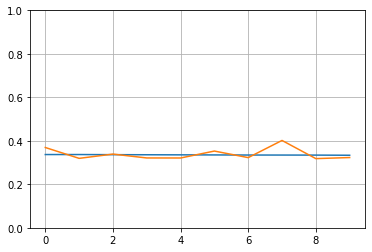

In [22]:
import pandas as pd

plt.plot(pd.DataFrame(history_1.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Another way to implement early stopping is to simply use the EarlyStopping callback. It will interrupt training when it measures no progress on the validation set for a number of epochs (defined by the patience argument), and it will optionally roll back to the best model. You can combine both callbacks to save checkpoints of your model (in case your computer crashes) and interrupt training early when there is no more progress (to avoid wasting time and resources):

In [0]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [23]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history_2 = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid,y_valid), callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test, verbose=0)    

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 77us/sample - loss: 0.3334 - val_loss: 0.3613
Epoch 2/100
11610/11610 [==============================] - 1s 65us/sample - loss: 0.3335 - val_loss: 0.3169
Epoch 3/100
11610/11610 [==============================] - 1s 67us/sample - loss: 0.3330 - val_loss: 0.3355
Epoch 4/100
11610/11610 [==============================] - 1s 65us/sample - loss: 0.3326 - val_loss: 0.3176
Epoch 5/100
11610/11610 [==============================] - 1s 63us/sample - loss: 0.3322 - val_loss: 0.3187
Epoch 6/100
11610/11610 [==============================] - 1s 68us/sample - loss: 0.3319 - val_loss: 0.3497
Epoch 7/100
11610/11610 [==============================] - 1s 65us/sample - loss: 0.3314 - val_loss: 0.3228
Epoch 8/100
11610/11610 [==============================] - 1s 64us/sample - loss: 0.3314 - val_loss: 0.4040
Epoch 9/100
11610/11610 [==============================] - 1s 63us/sample - loss: 0.331

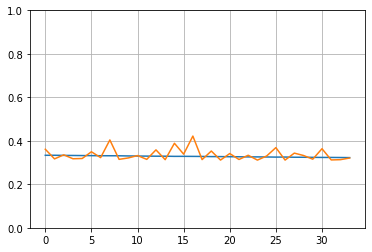

In [24]:
plt.plot(pd.DataFrame(history_2.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

If you need extra control, you can easily write your own custom callbacks. As an example of how to do that, the following custom callback will display the ratio between the validation loss and the training loss during training (e.g., to detect overfitting):

In [0]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):

  def on_epoch_end(self, epoch, logs):
    print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [27]:
val_train_ratio_cb = PrintValTrainRatioCallback()

history_3 = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), callbacks=[val_train_ratio_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11392/11610 [============================>.] - ETA: 0s - loss: 0.3242
val/train: 0.98
11610/11610 [==============================] - 1s 64us/sample - loss: 0.3255 - val_loss: 0.3175
Epoch 2/10
11232/11610 [============================>.] - ETA: 0s - loss: 0.3252
val/train: 0.96
11610/11610 [==============================] - 1s 65us/sample - loss: 0.3252 - val_loss: 0.3122
Epoch 3/10
10816/11610 [==========================>...] - ETA: 0s - loss: 0.3262
val/train: 0.97
11610/11610 [==============================] - 1s 66us/sample - loss: 0.3247 - val_loss: 0.3138
Epoch 4/10
11488/11610 [============================>.] - ETA: 0s - loss: 0.3254
val/train: 0.96
11610/11610 [==============================] - 1s 63us/sample - loss: 0.3244 - val_loss: 0.3124
Epoch 5/10
11200/11610 [===========================>..] - ETA: 0s - loss: 0.3260
val/train: 0.96
11610/11610 [==============================] - 1s 65us/sample - loss: 0.3241 - val